In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch as t
import torch.nn as nn
import pytorch_lightning as pl
import pandas as pd
from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.transforms import Compose, RandomApply
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [3]:
from src.data.dataset import BirdMelTrainDataset, EBIRD_CODE_TO_INDEX, INDEX_TO_EBIRD_CODE
from src.data.transforms import RandomTimeResize, RandomTimeShift

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('../data/raw/birdsong-recognition/train.csv')
df = df[df['filename'] != 'XC313679.mp3']
df = df[df['duration'] < 65]
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['ebird_code'])
train_dataset = BirdMelTrainDataset(
    train_df,
    '../data/processed/mel_specs_train/',
    False,
    Compose([
        RandomApply([RandomTimeShift(1.0)], 0.8),
        RandomApply([RandomTimeResize(resize_mode='bilinear')], 0.5),
        TimeMasking(10),
        FrequencyMasking(8),
    ])
)

test_dataset = BirdMelTrainDataset(
    test_df,
    '../data/processed/mel_specs_train/',
    False
)

In [6]:
max_log = max([t.log(t.max(x['mel_spec']) + 0.0001) for x in train_dataset])

In [7]:
min_log = min([t.log(t.min(x['mel_spec']) + 0.0001) for x in train_dataset])

In [8]:
# Pad sequences to the same length and to closest round 100 mel frames ~ 1.15 sec
def collate(batch):
    # print('Hmm')
    batch_size = len(batch)
    
    lengths = [x['mel_spec'].size(1) for x in batch]
    max_length = max(lengths)
    
    n_frames = 400
    k = (max_length // n_frames) + 1
    padded_length = k * n_frames
    
    n_mels = batch[0]['mel_spec'].size(0)
    
    batched_mels = t.zeros(batch_size, n_mels, padded_length)
    
    segment_lengths = t.FloatTensor([(length // n_frames) + 1 for length in lengths])
    
    with t.no_grad():
        for i, item in enumerate(batch):
            mel_spec = t.log(item['mel_spec'] + 0.0001)
            mel_spec = (mel_spec - min_log) / (min_log - max_log)
            batched_mels[i, :, :mel_spec.size(1)] = mel_spec
    
    primary_labels = [x['primary_label'] for x in batch]
    secondary_labels = [x['secondary_labels'] for x in batch]
    durations = [x['duration'] for x in batch]
    
    encoded_ebird_codes = t.cat([x['encoded_ebird_codes'].view(1, -1) for x in batch], dim=0)
    primary_ebird_codes = [x['primary_ebird_code'] for x in batch]
    secondary_ebird_codes = list(chain(*[x['secondary_ebird_codes'] for x in batch]))
    
    return {
        'mel_specs': batched_mels,
        'original_lengths': lengths,
        'encoded_ebird_codes': encoded_ebird_codes,
        'primary_ebird_codes': primary_ebird_codes,
        'secondary_ebird_codes': secondary_ebird_codes,
        'primary_labels': primary_labels,
        'secondary_labels': secondary_labels,
        'segment_lengths': segment_lengths,
        'durations': durations,
    }

In [9]:
t.max(t.log(train_dataset[0]['mel_spec']))

tensor(10.0067)

In [10]:
t.min(t.log(train_dataset[0]['mel_spec'] + 0.0001))

tensor(-9.2103)

In [48]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=264, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [67]:
class ModelWithResNet(pl.LightningModule):
    def __init__(self, n_classes, n_mels, segment_size, lr=0.001):
        super().__init__()
        
        self.resnet = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=n_classes)
        self.linear = nn.Linear(512 * 2, 264)
        
        self.n_mels = n_mels
        self.segment_size = segment_size
        self.n_classes = n_classes
        self.lr = lr
        
    def forward(self, batch):
        batch_size = len(batch['mel_specs'])
        n_segments = int(max(batch['segment_lengths']))
        mel_specs = batch['mel_specs']
        
#         import pdb; pdb.set_trace()
        
        mel_specs = mel_specs.transpose(-2, -1).reshape(n_segments * batch_size, 1, -1, self.n_mels).transpose(-2, -1)
        x = self.resnet(mel_specs)
#         print(x.shape)
        x1 = t.mean(x, dim=0)
        x2, _ = t.max(x, dim=0)
        x = t.cat((x1, x2), dim=0)
        x = t.flatten(x)
        x = self.linear(x)
        return x.view(1, -1)
    
    def training_step(self, batch, batch_idx):
        prediction = self(batch)
        loss = t.nn.functional.binary_cross_entropy_with_logits(
            prediction,
            batch['encoded_ebird_codes']
        )
        tensorboard_logs = {'train/loss': loss.item()}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        prediction = self(batch)
        loss = t.nn.functional.binary_cross_entropy_with_logits(
            prediction,
            batch['encoded_ebird_codes']
        )
        predicted_ranking = t.argsort(prediction, dim=1, descending=True)
        expected_indices = [EBIRD_CODE_TO_INDEX[x] for x in batch['primary_ebird_codes']]
        
        top_1 = []
        top_3 = []
        top_5 = []
        
        for expected_index, ranking in zip(expected_indices, predicted_ranking):
            if expected_index in ranking[:1]:
                top_1.append(1)
            else:
                top_1.append(0)
                
            if expected_index in ranking[:3]:
                top_3.append(1)
            else:
                top_3.append(0)
            
            if expected_index in ranking[:5]:
                top_5.append(1)
            else:
                top_5.append(0)
        return {'val_loss': loss, 'top_1': top_1, 'top_3': top_3, 'top_5': top_5}
    
    def validation_epoch_end(self, outputs):
        val_loss_mean = t.stack([x['val_loss'] for x in outputs]).mean()
        top_1 = np.mean(list(chain(*[x['top_1'] for x in outputs])))
        top_3 = np.mean(list(chain(*[x['top_3'] for x in outputs])))
        top_5 = np.mean(list(chain(*[x['top_5'] for x in outputs])))
        tensorboard_logs = {'val/loss': val_loss_mean, 'val/top_1': top_1, 'val/top_3': top_3, 'val/top_5': top_5}
        return {'val_loss': val_loss_mean, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        optimizer = t.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = t.optim.lr_scheduler.CyclicLR(
            optimizer,
            self.lr / 4,
            self.lr * 2,
            step_size_up=500,
            cycle_momentum=False
        )
        return [optimizer], [{
            'scheduler': scheduler,
            'interval':'step',
        }]
        
        


In [68]:
train_dataloader = t.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate,
    num_workers=12,
)

In [69]:
test_dataloader = t.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate,
    num_workers=8,
)

In [70]:
model = ModelWithResNet(264, 128, 400)

In [71]:
trainer = pl.Trainer(gpus=1, accumulate_grad_batches=16, row_log_interval=64, auto_lr_find=True, callbacks=[pl.callbacks.LearningRateLogger()])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model, train_dataloader, test_dataloader)


  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 11 M  
1 | linear | Linear | 270 K 


Learning rate set to 0.000630957344480193

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 11 M  
1 | linear | Linear | 270 K 


In [ ]:
test_dataset[15]

In [ ]:
model = model.eval()
model = model.cpu()

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, f1_score

In [ ]:
predictions = []
expectations = []
for batch in tqdm(test_dataloader):
    with t.no_grad():
        prediction = t.sigmoid(model(batch)).numpy()
    expectation = batch['encoded_ebird_codes'].numpy()
    predictions.append(prediction)
    expectations.append(expectation)

In [ ]:
a = np.concatenate(predictions)

In [27]:
b = np.concatenate(expectations)

In [ ]:
class_wise_roc_auc

In [31]:
average_precision_score(b, a, average='macro')

0.11960676157384229

In [32]:
average_precision_score(b, a, average='micro')

0.05250861648540862

In [33]:
roc_auc_score(b, a, average='macro')

0.8655299325456277

In [34]:
roc_auc_score(b, a, average='micro')

0.868520349183721

In [54]:
f1_score(b, a > 0.5, average='samples')

0.29151976895862486

In [73]:
np.where(b > 0.99)[0][:100]

array([ 0,  1,  1,  2,  3,  4,  5,  6,  6,  7,  7,  7,  7,  7,  8,  9,  9,
       10, 11, 12, 13, 13, 14, 15, 15, 16, 16, 17, 18, 19, 19, 20, 21, 21,
       22, 23, 24, 24, 25, 26, 27, 27, 27, 27, 27, 28, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 38, 38, 38, 38, 39, 40, 41, 42, 43, 44, 45,
       45, 45, 45, 45, 46, 47, 47, 47, 48, 48, 48, 48, 48, 49, 50, 51, 52,
       53, 53, 54, 55, 55, 55, 55, 55, 56, 57, 58, 59, 60, 61, 62])

In [74]:
np.where(b > 0.99)[1][:100]

array([113, 192, 263, 146, 107,  29, 211,  54, 130,   8,  16,  66,  80,
       196, 166, 170, 192, 215,  10,  43,  54, 138, 128, 155, 243,  95,
       127,  63, 212, 151, 191, 194,  54, 146,  10, 195, 151, 163,  48,
        26,  90, 129, 180, 199, 221,  32,  54,  64,  84, 260, 193, 103,
       221,  95, 212, 187,   8,  33,  73,  93, 157,  40, 169, 157, 160,
       167, 197,  83, 158, 224, 237, 262, 190,   4, 170, 181,   8,  61,
       116, 199, 231, 160, 103, 250, 195,  33, 217,  94,   3,  58,  96,
       196, 225,  63, 261,  20, 239, 162, 248,  24])

In [ ]:
np.nonzero()

In [79]:
np.argsort(a)[:10, :5]

array([[238, 204, 102, 165, 205],
       [226, 238, 154, 144,  69],
       [ 47, 122, 205, 200, 191],
       [142, 179, 238,  69, 102],
       [ 18,  75, 108, 175,  88],
       [165, 177, 248, 142, 254],
       [122,  67,  17, 241,  75],
       [102,  47, 204, 191, 238],
       [ 47,   6, 191, 217,  57],
       [219, 191,  85, 137,   9]])

In [165]:
i = 15
prediction = model(collate([test_dataset[i]]))
ranking = t.argsort(prediction[0], descending=True)
ebird_code_ranking = [INDEX_TO_EBIRD_CODE[x] for x in ranking]
print('Expected: ', test_dataset[i]['primary_ebird_code'], '; ', test_dataset[i]['secondary_ebird_codes'])
print('Top 10 predicted: ', list(zip(ebird_code_ranking[:20], t.sigmoid(prediction[0][ranking[:20]]).tolist())))

Expected:  semplo ;  []
Top 10 predicted:  [('semplo', 0.9909865260124207), ('baisan', 0.5913958549499512), ('eargre', 0.5131775736808777), ('leasan', 0.2800365388393402), ('snobun', 0.14021538197994232), ('sposan', 0.058637332171201706), ('pecsan', 0.0476604662835598), ('saypho', 0.04681962728500366), ('semsan', 0.039814699441194534), ('gnwtea', 0.028566207736730576), ('greyel', 0.028048895299434662), ('pingro', 0.02715337462723255), ('norpin', 0.024820655584335327), ('phaino', 0.024776224046945572), ('whfibi', 0.021495651453733444), ('lobdow', 0.019899779930710793), ('casfin', 0.0190047025680542), ('logshr', 0.017313508316874504), ('wessan', 0.01633535511791706), ('westan', 0.014720698818564415)]


['ameavo',
 'gockin',
 'snogoo',
 'wessan',
 'brespa',
 'grhowl',
 'bkbwar',
 'amepip',
 'veery',
 'redhea']

In [147]:
import librosa
import librosa.display

In [148]:
def plot_data(mel_spec, ax):
    # mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = mel_spec
    librosa.display.specshow(mel_spec_db, sr=44100, hop_length=512, x_axis='time', y_axis='mel', ax=ax);

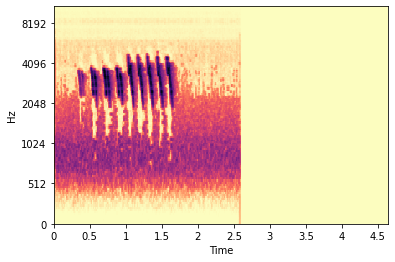

In [149]:
plot_data(collate([test_dataset[11]])['mel_specs'][0].numpy(), plt.gca())

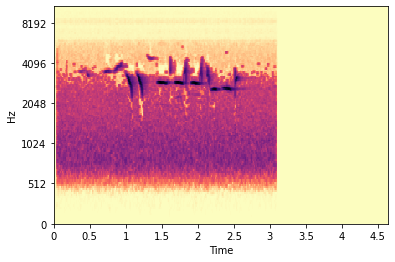

In [150]:
plot_data(collate([test_dataset[19]])['mel_specs'][0].numpy(), plt.gca())

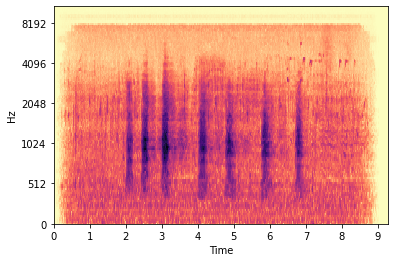

In [155]:
plot_data(collate([test_dataset[22]])['mel_specs'][0].numpy(), plt.gca())

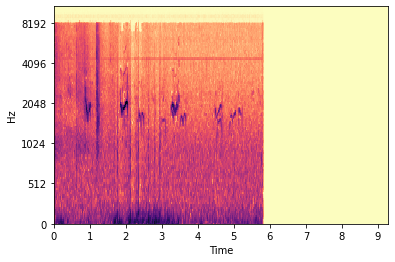

In [166]:
plot_data(collate([test_dataset[15]])['mel_specs'][0].numpy(), plt.gca())

In [143]:
def plot_data(mel_spec, ax):
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec_db, sr=44100, hop_length=512, x_axis='time', y_axis='mel', ax=ax);

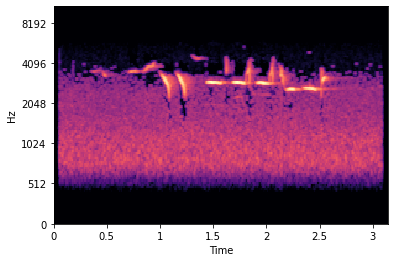

In [144]:
plot_data(test_dataset[19]['mel_spec'], plt.gca())

In [145]:
collate([test_dataset[19]])['mel_specs'][0].shape

torch.Size([128, 400])